In [83]:
# Articles
# - https://jyx.jyu.fi/handle/123456789/78083

In [84]:
# Notes

# Important paper  => Kania2021_Chapter_InteractiveMultiobjectiveOptim.pdf

In [85]:
# 
"""
Toimitusaika = 12kk
Tilauskustannus = 100 + 100

Ketjutettutilaus eteenpäin


Liquid zone -> 
Frozen zone -> määritelty materiaali tulee, oli tilattu tai ei

Vuoden jaksotettut tilaukset -> Milloin tilataan ja paljon
"""

'\nToimitusaika = 12kk\nTilauskustannus = 100 + 100\n\nKetjutettutilaus eteenpäin\n\n\nLiquid zone -> \nFrozen zone -> määritelty materiaali tulee, oli tilattu tai ei\n\nVuoden jaksotettut tilaukset -> Milloin tilataan ja paljon\n'

In [86]:
import pandas as pd
import numpy as np

df = pd.read_excel('Demand_data_case.xlsx')

months = []
# month = 1
# for i in range(1, 109):
#     if month % 13 == 0:
#         month = 1
#     months.append(month)
#    month = month + 1
df['months'] = list(range(1,109))
df

print(df)

     Month  Demand (pcs)  months
0    m_001            11       1
1    m_002            12       2
2    m_003            10       3
3    m_004             8       4
4    m_005            12       5
..     ...           ...     ...
103  m_104             3     104
104  m_105             0     105
105  m_106             0     106
106  m_107             3     107
107  m_108             5     108

[108 rows x 3 columns]


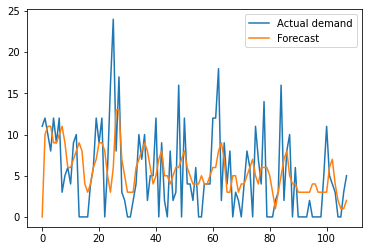

In [87]:
# Sales forcecast
"""
ARIMA
"""

from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

model = ARIMA(df['Demand (pcs)'], order=(5,1,1))
model_fit = model.fit()
#print(model_fit.summary())

# Actual vs Fitted
forecast = model_fit.predict().astype(int)
plt.plot(df['Demand (pcs)'], label="Actual demand")
plt.plot(forecast, label="Forecast")
plt.legend()
plt.show()


In [88]:
# x1 = np.array(df['Demand (pcs)'])  # Demand
x2 = np.array(df['months'])        # Months / timeline
x3 = np.array(df['Demand (pcs)'])  # Orders

x = pd.array([forecast, x2, x3])

x = []
for i in range(len(x2)):
    x.append([forecast[i], x2[i], x3[i]])

x = np.asarray(x)

print(x.shape)
print(x[:, 0])
print(x[:, 2])

(108, 3)
[ 0 10 11 11  9  9 10 11  9  6  6  7  8  9  8  4  3  4  6  7  9  9  8  5
  3  6 13 13  7  5  3  3  3  6  7  8  9  8  6  4  5  7  8  5  5  4  5  6
  6  7  8  6  5  4  4  4  5  4  4  5  6  6  8  9  7  3  3  5  5  3  4  4
  5  6  7  5  4  6  6  6  5  3  1  3  5  7  8  5  4  4  3  3  3  3  3  4
  4  3  3  3  3  6  7  4  2  1  1  2]
[11 12 10  8 12  9 12  3  5  6  4  9 10  0  0  0  0  4  6 12  9 12  0  6
 16 24  8 17  3  2  0  0  2  4 10  7 10  2  5  5 12  0  9  2  0  8  2  3
 16  0 12  4  4  2  6  0  0  4  4  4 12 12 18  2  9  4  8  0  3  2  0  4
  8  6  0 11  7  4 14  0  0  0  2  3 16  2  8 10  0  6  0  0  0  0  2  0
  0  0  0  5 11  5  4  3  0  0  3  5]


In [89]:
# Variables
from desdeo_problem import variable_builder

var_names = ['forecast', 'months', 'demand']

initial_values = [1, 1, 1]
lower_bounds = [0, 1, 0]
upper_bounds = [25, 108, 25]

variables = variable_builder(var_names, initial_values, lower_bounds, upper_bounds)

[0.         1.2        0.90909091 0.72727273 1.33333333 1.
 1.2        0.27272727 0.55555556 1.         0.66666667 1.28571429
 1.25       0.         0.         0.         0.         1.
 1.         1.71428571 1.         1.33333333 0.         1.2
 5.33333333 4.         0.61538462 1.30769231 0.42857143 0.4
 0.         0.         0.66666667 0.66666667 1.42857143 0.875
 1.11111111 0.25       0.83333333 1.25       2.4        0.
 1.125      0.4        0.         2.         0.4        0.5
 2.66666667 0.         1.5        0.66666667 0.8        0.5
 1.5        0.         0.         1.         1.         0.8
 2.         2.         2.25       0.22222222 1.28571429 1.33333333
 2.66666667 0.         0.6        0.66666667 0.         1.
 1.6        1.         0.         2.2        1.75       0.66666667
 2.33333333 0.         0.         0.         2.         1.
 3.2        0.28571429 1.         2.         0.         1.5
 0.         0.         0.         0.         0.66666667 0.
 0.         0.         

/var/folders/xp/ptg6qcks2j72m9d_slq4zjs80000gn/T/ipykernel_19259/2563416788.py:18: RuntimeWarning:

divide by zero encountered in true_divide



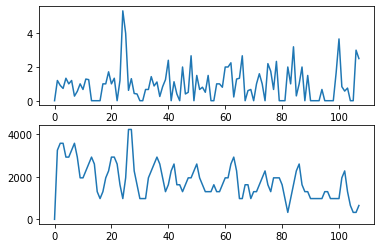

In [90]:
# Objectives
"""
f1 -> Availability / No stock out -> service level / fill rate
    Maximize
    Total Number of Customer Orders Shipped / Number of Customer Orders Filled

f2 -> Holding cost
    Minimize

    Q = Optimal order quantity
    H = Holding cost per unit => Fixed 10% of unit price
    Q/2 x H
f3 -> Inventory turnover rate # Not part of this project
"""
from desdeo_problem import ScalarObjective

def obj_1(x):
    ret = x[:, 2] / x[:, 0]
    ret[ret == np.inf] = 0
    return ret

def obj_2(x):
    return (x[:, 0] / 2) * 6500*0.1

f1 = ScalarObjective('y1', obj_1, maximize=True)
f2 = ScalarObjective('y2', obj_2, maximize=True)

f_1 = obj_1(x)
f_2 = obj_2(x)

print(f_1)
print(f_2)

fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(f_1)

ax2.plot(f_2)


In [91]:
# Constraits
"""
c1 -> Stock greater than zero
c2 -> Max stock amount
"""
from desdeo_problem import ScalarConstraint

def const_func_1(x, y):
    ret = []
    for yi in y:
        ret.append(1 - yi[0])
    return np.array(ret)

c1 = ScalarConstraint('c_1', 3, 2, const_func_1)

def const_func_2(x, y):
    ret = []
    for yi in y:
        ret.append(5000 - yi[1])
    return np.array(ret)

c2 = ScalarConstraint('c_2', 3, 2, const_func_2)

In [92]:

# Safety stock

R = np.mean(x[0])
std_R = np.std(x[0])
L = 12 # lead time - 12 months
#sL = 0 # lead time standard deviation
CSL = 0.9 # cycle service level

SS = (CSL * std_R * L)**0.5
print('safety stock', SS)

print('Demand mean / average', R)
print('Demand standard deviation', std_R)

safety stock 7.32385089503499
Demand mean / average 4.0
Demand standard deviation 4.96655480858378


In [93]:
# Surrogate
from desdeo_problem import VectorDataObjective as VDO
from desdeo_problem.surrogatemodels.SurrogateModels import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern

#data = np.hstack((x, f_1, f_2))
#print(data)

# data = {
#     'x1': x[0],  # demand / forecast
#     'x2': x[1],  # months
#     'x3': x[2],  # orders
#     'f1': f_1, 
#     'f2': f_2
# }

# datapd = pd.DataFrame(data=data) # columns=['x1', 'x2', 'f1', 'f2']

# print(datapd)
# obj = VDO(data=datapd, name=['f1', 'f2'])

# obj.train(models=GaussianProcessRegressor, model_parameters={'kernel': Matern(nu=1.5)})
 
# print(obj.evaluate(np.asarray([[3,2, 4]]), use_surrogate=True))

In [94]:
# Problem

#from desdeo_problem import DataProblem
from desdeo_problem import MOProblem

#maximize = pd.DataFrame([[True, True]], columns=['f1','f2'])
prob = MOProblem(objectives=[f1,f2], variables=variables, constraints=[c1, c2])

#prob.train(GaussianProcessRegressor)

print(prob.evaluate(x))

Evaluation Results Object 
Objective values are: 
[[0.00000000e+00 0.00000000e+00]
 [1.20000000e+00 3.25000000e+03]
 [9.09090909e-01 3.57500000e+03]
 [7.27272727e-01 3.57500000e+03]
 [1.33333333e+00 2.92500000e+03]
 [1.00000000e+00 2.92500000e+03]
 [1.20000000e+00 3.25000000e+03]
 [2.72727273e-01 3.57500000e+03]
 [5.55555556e-01 2.92500000e+03]
 [1.00000000e+00 1.95000000e+03]
 [6.66666667e-01 1.95000000e+03]
 [1.28571429e+00 2.27500000e+03]
 [1.25000000e+00 2.60000000e+03]
 [0.00000000e+00 2.92500000e+03]
 [0.00000000e+00 2.60000000e+03]
 [0.00000000e+00 1.30000000e+03]
 [0.00000000e+00 9.75000000e+02]
 [1.00000000e+00 1.30000000e+03]
 [1.00000000e+00 1.95000000e+03]
 [1.71428571e+00 2.27500000e+03]
 [1.00000000e+00 2.92500000e+03]
 [1.33333333e+00 2.92500000e+03]
 [0.00000000e+00 2.60000000e+03]
 [1.20000000e+00 1.62500000e+03]
 [5.33333333e+00 9.75000000e+02]
 [4.00000000e+00 1.95000000e+03]
 [6.15384615e-01 4.22500000e+03]
 [1.30769231e+00 4.22500000e+03]
 [4.28571429e-01 2.2750000

/var/folders/xp/ptg6qcks2j72m9d_slq4zjs80000gn/T/ipykernel_19259/2563416788.py:18: RuntimeWarning:

divide by zero encountered in true_divide



In [95]:
# Optimize
from desdeo_emo.EAs.NSGAIII import NSGAIII

evolver = NSGAIII(prob, n_iterations=2, n_gen_per_iter=10, population_size=10)

while evolver.continue_evolution():
    evolver.iterate()

individuals, solutions = evolver.end()

print(individuals.shape)

print(solutions.shape)


# fig, (ax1, ax2) = plt.subplots(2)
# ax1.plot(individuals[:,0], individuals[:,1])

# ax2.plot(solutions[:,0], solutions[:,1])

import plotly.graph_objects as go

fig1 = go.Figure(
    data=go.Scatter3d(
        x=individuals[:,0], 
        y=individuals[:,1], 
        z=individuals[:,2], 
        mode="markers"))
fig1

(10, 3)
(10, 2)


/var/folders/xp/ptg6qcks2j72m9d_slq4zjs80000gn/T/ipykernel_19259/2563416788.py:18: RuntimeWarning:

divide by zero encountered in true_divide



In [96]:
fig2 = go.Figure(data=go.Scatter(x=solutions[:,0],
                                   y=solutions[:,1],
                                   mode="markers",
                                   marker_size=5))
fig2
